이번 튜토리얼에서는 웹 검색 도구를 통해 챗봇에 웹 검색 기능수행하는 Agent 을 추가합니다.

LLM 에 도구를 바인딩하여 LLM 에 입력된 요청에 따라 필요시 웹 검색 도구(Tool)를 호출하는 Agent 을 구축합니다.

뿐만아니라, 조건부 엣지를 통해 도구 호출 여부에 따라 다른 노드로 라우팅하는 방법도 함께 배워봅니다.



In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()


True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph")


LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph


In [3]:
from langchain_teddynote.tools.tavily import TavilySearch

# 검색 도구 생성
tool = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [tool]

# 도구 실행
tool.invoke("테디노트 랭체인 튜토리얼")


[{'title': '랭체인 (langchain)의 OpenAI GPT 모델 (ChatOpenAI) 사용법 (1) - 테디노트',
  'url': 'https://teddylee777.github.io/langchain/langchain-tutorial-01/',
  'content': '② LangChain 한국어 튜토리얼 바로가기 👀 ③ 랭체인 노트 무료 전자책(wikidocs) 바로가기 🙌 ④ RAG 비법노트 LangChain 강의오픈 바로가기 🙌 ⑤ 서울대 PyTorch 딥러닝 강의 바로가기 🙌 랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) 2023년 09월 28일 5 분 소요 목차 🌱 랭체인의 주요 기능 🌱 환경설정 API KEY 발급 모듈 설치(openai, langchain) 🔥 ChatOpenAI 🔥 프롬프트 템플릿의 활용 LLMChain 객체 ① run() ② apply() ③ generate() ④ 2개 이상의 변수를 템플릿 안에 정의 ⑤ 스트리밍(streaming) 언어 모델을 활용한 애플리케이션 개발을 돕는 프레임워크인 랭체인(LangChain) 에 대해 깊이 있게 다뤄보고자 합니다. 튜토리얼은 시리즈 형식으로 구성되어, 시리즈를 거듭하면서 랭체인(LangChain) 을 통해 언어 모델 기반의 애플리케이션 개발은 더욱 간결하고 효과적으로 이루어질 수 있습니다. 추론 능력: 제공된 문맥에 기반하여 어떤 대답을 할지, 또는 어떠한 액션을 취할지에 대한 추론이 가능합니다. 특히, 이러한 사용 준비된 체인은 초보자도 랭체인을 쉽게 시작할 수 있게 도와주며, 복잡한 애플리케이션을 계획하는 전문가들은 기존 체인을 손쉽게 커스터마이징하거나 새롭게 구축할 수 있게 도와줍니다.',
  'score': 0.854509,
  'raw_content': "랭체인(langchain)의 OpenAI GPT 모델(ChatOpenAI) 사용법 (1) - 테디노트\n\nSkip to primary navigation\nSkip

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]


In [ ]:
from langchain_openai import ChatOpenAI

# LLM 정의
llm = ChatOpenAI(
    api_key="ollama",
    model="llama3.2:1b",
    base_url="http://localhost:11434/v1",
)

# LLM에 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


In [8]:
# 노드 함수 정의
def chatbot(state: State):
    answer = llm_with_tools.invoke(state["messages"])
    # 메시지 목록 반환
    return {"messages": [answer]}  # 자동으로 add_messages 적용


In [9]:
from langgraph.graph import StateGraph

# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)


도구 노드(Tool Node)
- 다음으로, 도구가 호출될 경우 실제로 실행할 수 있는 함수를 만들어야 합니다. 이를 위해 새로운 노드에 도구를 추가합니다.
- 가장 최근의 메시지를 확인하고 메시지에 tool_calls가 포함되어 있으면 도구를 호출하는 BasicToolNode를 구현합니다.
- 지금은 직접 구현하지만, 나중에는 LangGraph의 pre-built 되어있는 ToolNode 로 대체할 수 있습니다.

In [10]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """Run tools requested in the last AIMessage node"""

    def __init__(self, tools: list) -> None:
        # 도구 리스트
        self.tools_list = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 메시지가 존재할 경우 가장 최근 메시지 1개 추출
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # 도구 호출 결과
        outputs = []
        for tool_call in message.tool_calls:
            # 도구 호출 후 결과 저장
            tool_result = self.tools_list[tool_call["name"]].invoke(tool_call["args"])
            outputs.append(
                # 도구 호출 결과를 메시지로 저장
                ToolMessage(
                    content=json.dumps(
                        tool_result, ensure_ascii=False
                    ),  # 도구 호출 결과를 문자열로 변환
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {"messages": outputs}


# 도구 노드 생성
tool_node = BasicToolNode(tools=[tool])

# 그래프에 도구 노드 추가
graph_builder.add_node("tools", tool_node)


조건부 엣지(Conditional Edge)
- 도구 노드가 추가되면 conditional_edges를 정의할 수 있습니다.
- Edges는 한 노드에서 다음 노드로 제어 흐름을 라우팅합니다.

Conditional edges는 일반적으로 "if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 라우팅합니다. 이러한 함수는 현재 그래프 state를 받아 다음에 호출할 Node 를 나타내는 문자열 또는 문자열 목록 을 반환합니다.

아래에서는 route_tools라는 라우터 함수를 정의하여 챗봇의 출력에서 tool_calls를 확인합니다.

이 함수를 add_conditional_edges를 호출하여 그래프에 제공하면, chatbot 노드가 완료될 때마다 이 함수를 확인하여 다음으로 어디로 갈지 결정합니다.

조건은 도구 호출이 있으면 tools로, 없으면 END로 라우팅됩니다.

In [11]:
from langgraph.graph import START, END


def route_tools(
    state: State,
):
    if messages := state.get("messages", []):
        # 가장 최근 AI 메시지 추출
        ai_message = messages[-1]
    else:
        # 입력 상태에 메시지가 없는 경우 예외 발생
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # AI 메시지에 도구 호출이 있는 경우 "tools" 반환
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        # 도구 호출이 있는 경우 "tools" 반환
        return "tools"
    # 도구 호출이 없는 경우 "END" 반환
    return END


# `tools_condition` 함수는 챗봇이 도구 사용을 요청하면 "tools"를 반환하고, 직접 응답이 가능한 경우 "END"를 반환
graph_builder.add_conditional_edges(
    source="chatbot",
    path=route_tools,
    # route_tools 의 반환값이 "tools" 인 경우 "tools" 노드로, 그렇지 않으면 END 노드로 라우팅
    path_map={"tools": "tools", END: END},
)

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# 그래프 컴파일
graph = graph_builder.compile()


이는 그래프에 "chatbot" 노드가 실행될 때마다 도구를 호출하면 'tools'로 이동하고, 직접 응답하면 루프를 종료하라는 의미입니다.

사전 구축된 tools_condition처럼, 함수는 도구 호출이 없을 경우 END 문자열을 반환(그래프 종료) 합니다. 그래프가 END로 전환되면 더 이상 완료할 작업이 없으며 실행을 중지합니다.

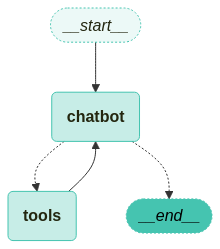

In [12]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)


In [14]:
from langchain_teddynote.messages import display_message_tree

question = "대한민국의 수도는?"

for event in graph.stream({"messages": [("user", question)]}):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        display_message_tree(value["messages"][-1])



STEP: chatbot

    content: "{"name": tavily_web_search,"parameters": {"query": 대한민국}}"
    additional_kwargs: {"refusal": None}
    response_metadata:
        token_usage: {"completion_tokens": 18, "prompt_tokens": 205, "total_tokens": 223, "completion_tokens_details": None, "prompt_tokens_details": None}
        model_name: "llama3.2:1b"
        system_fingerprint: "fp_ollama"
        id: "chatcmpl-193"
        finish_reason: "stop"
        logprobs: None
    type: "ai"
    name: None
    id: "run-b2efaa3d-e7fd-4c8d-a276-8d35979b30f3-0"
    example: False
    tool_calls:
    invalid_tool_calls:
    usage_metadata:
        input_tokens: 205
        output_tokens: 18
        total_tokens: 223
        input_token_details: {}
        output_token_details: {}
